In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [3]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Loading data functions

In [4]:
def load_data(in_file):
    input_f = open(in_file, "r")
    matrix = []
    for line in input_f:
        channels = [] #get channels
        for l in line.split("|"):
            samples = l.split(";")
            channels.append([float(i) for i in samples])
        matrix.append(channels)
        del channels
    input_f.close()
    return matrix

In [5]:
def load_labels(in_file):
    input_f = open(in_file, "r")
    labels = []
    for line in input_f:
        if ";" in line:
            labels.append(set(line.replace("\n","").split(";")))
        else:
            labels.append(line.replace("\n",""))
    input_f.close()
    return labels

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

def load_dataset():
    X_train_data = load_data("data/data_train.txt")
    y_train_lat_labels = load_labels("data/labels_train.txt")
    print ("initial data: ", np.array(X_train_data).shape)

    X_test_data = load_data("data/data_test.txt")
    y_test_lat_labels = load_labels("data/labels_test.txt")
    y_test_lat_labels = ["_with_".join(i) for i in y_test_lat_labels]
    print ("initial data: ", np.array(X_test_data).shape)
    
    ##########################################
    X_train_big = []
    X_train_big.extend(X_train_data)
    X_train_big.extend(X_test_data)
    X_train_big = np.array(X_train_big)

    y_train_lat_big = []
    y_train_lat_big.extend(y_train_lat_labels)
    y_train_lat_big.extend(y_test_lat_labels)
    
    y_train_lat_big_list = []
    for i in y_train_lat_big:
        if type(i) is list:
            y_train_lat_big_list.append(i)
        else:
            y_train_lat_big_list.append([i])

    mlb = MultiLabelBinarizer()
    y_train_big =  mlb.fit_transform(y_train_lat_big_list) 

    X_new_data = load_data("data/data_new.txt")
    print ("initial data: ", np.array(X_new_data).shape)
    return X_train_big, y_train_big, X_new_data, mlb

# Other functions

In [94]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    plt.figure(figsize=(9,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
from sklearn.cross_validation import KFold
def model_evaluation(X_train, y_train, N): 
    return KFold(n=len(X_train), shuffle=True, n_folds=N, random_state=42)       

In [8]:
def get_dfmax(X):
    X_max = []
    S_max = []
    for x in X:
        s_m = []
        for s in x:
            s_m.append(max(np.array(s)))
        S_max.append(s_m)
    for x,s_max in zip(X,S_max):        
        #print ("s_max: ", s_max)
        m = list(map(list, zip(*x))) 
        X_m = []
        for s in m:
            s_new = []
            for i,ss in zip(s,s_max):
                if i != ss:
                    s_new.append(0)
                else:
                    s_new.append(i)
            X_m.append(s_new)
        X_max.append(X_m)
    return X_max

# Working block

# Learning on raw data

Загрузим данные.
<br> X_train содержит вещества-маркеры и их смеси, X_new - это игрушки.
<br> y_train_bin - это метки классов обучающей выборки в multilabel-формате, y_train - те же метки, что только в виде названий веществ.

In [82]:
X_train, y_train_bin, X_new, mlb = load_dataset()

y_train2 = load_labels("data/labels_all.txt")
y_train = []
for item in y_train2:
    y_train.append([item])
y_train = mlb.fit_transform(y_train)

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


In [83]:
X_train_raw = X_train
X_train_raw = np.array(X_train_raw)
n_samples = len(X_train_raw)
X_train_raw = X_train_raw.reshape((n_samples, -1))

In [84]:
X_new_raw = X_new
X_new_raw = np.array(X_new_raw)
n_samples = len(X_new_raw)
X_new_raw = X_new_raw.reshape((n_samples, -1))

In [85]:
X_train_corr = []
for X, y in zip(X_train, y_train2):
    X = list(map(list, zip(*X)))
    df = pd.DataFrame(X, index=None, columns=["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
    corr = df.corr()
    corr = (corr - corr.mean()) / (corr.max() - corr.min())
    X_train_corr.append(corr.as_matrix())
    
X_new_corr = []
for X, y in zip(X_train, y_train2):
    X = list(map(list, zip(*X)))
    df = pd.DataFrame(X, index=None, columns=["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
    corr = df.corr()
    corr = (corr - corr.mean()) / (corr.max() - corr.min())
    X_new_corr.append(corr.as_matrix())

In [86]:
X_train_corr = np.array(X_train_corr)
n_samples = len(X_train_corr)
X_train_corr = X_train_corr.reshape((n_samples, -1))

In [87]:
X_train_raw = np.array(X_train_raw)
X_train_corr = np.array(X_train_corr)
X_t = np.hstack((X_train_raw,X_train_corr))

In [88]:
print (np.array(X_train_raw).shape)
print (np.array(X_train_corr).shape)
print (np.array(X_t).shape)

(40, 968)
(40, 64)
(40, 1032)


In [89]:
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X_t, y_train2, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

#plt.figure(figsize=(15,20))

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')

ValueError: Invalid parameter anova for estimator SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [90]:
from numpy.linalg import matrix_rank 
print ("Ранг матрицы веществ: ", matrix_rank(X_train_raw))
print ("Ранг матрицы игрушек: ", matrix_rank(X_new_raw))

Ранг матрицы веществ:  40
Ранг матрицы игрушек:  75


In [91]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train_raw)
df_std = std_scale.transform(X_train_raw)

minmax_scale = preprocessing.MinMaxScaler().fit(X_train_raw)
df_minmax = minmax_scale.transform(X_train_raw)

robust_scale = preprocessing.RobustScaler().fit(X_train_raw)
df_robust = robust_scale.transform(X_train_raw)

maxabs_scale = preprocessing.MaxAbsScaler().fit(X_train_raw)
df_maxabs = maxabs_scale.transform(X_train_raw)

norma = preprocessing.Normalizer().fit(X_train_raw)
df_norma = norma.transform(X_train_raw)

In [257]:
print('Mean before standardization:{:.2f}'.format(X_train_raw.mean()))
print('Standard deviation before standardization:{:.2f}'.format(X_train_raw.std()))
print ("\nStandardScaler")
print('Mean after standardization:{:.2f}'.format(df_std.mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_std.std()))
print ("\nMinMaxScaler")
print('Mean after standardization:{:.2f}'.format(df_minmax.mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_minmax.std()))
print ("\nRobustScaler")
print('Mean after standardization:{:.2f}'.format(df_robust.mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_robust.std()))
print ("\nMaxAbsScaler")
print('Mean after standardization:{:.2f}'.format(df_maxabs.mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_maxabs.std()))
print ("\nNormalizer")
print('Mean after standardization:{:.2f}'.format(df_norma.mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_norma.std()))

Mean before standardization:5.52
Standard deviation before standardization:6.81

StandardScaler
Mean after standardization:-0.00
Standard deviation after standardization:1.00

MinMaxScaler
Mean after standardization:0.36
Standard deviation after standardization:0.25

RobustScaler
Mean after standardization:0.15
Standard deviation after standardization:0.99

MaxAbsScaler
Mean after standardization:0.34
Standard deviation after standardization:0.28

Normalizer
Mean after standardization:0.02
Standard deviation after standardization:0.02


SVM train accuracy for Raw 0.95
                                precision    recall  f1-score   support

                   azetaldegid       1.00      1.00      1.00         4
                        azeton       1.00      1.00      1.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       1.00      1.00      1.00         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.82      1.00      0.90         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       1.00      1.00      1.00         1
                    etilazetat       1.00      1.00      1.00         4
                         fenol 

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


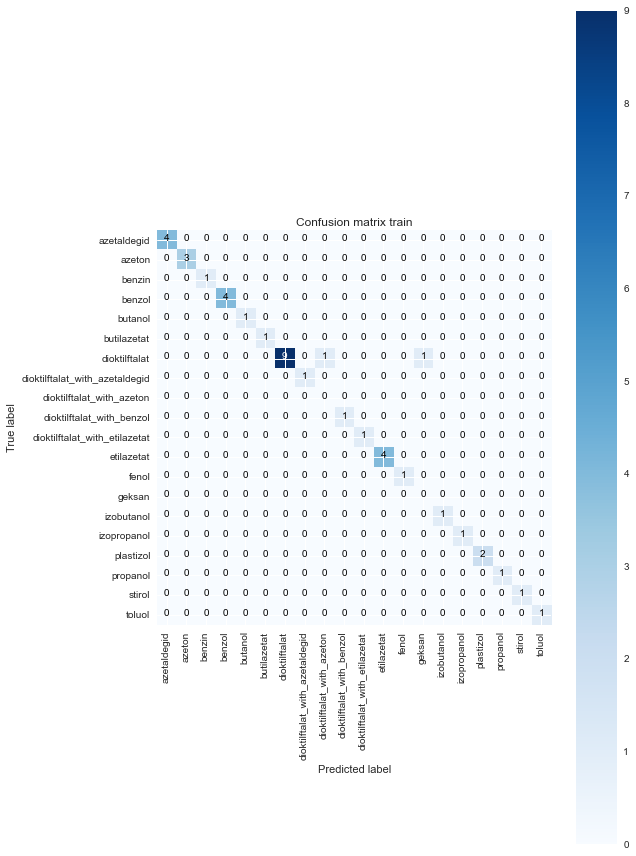

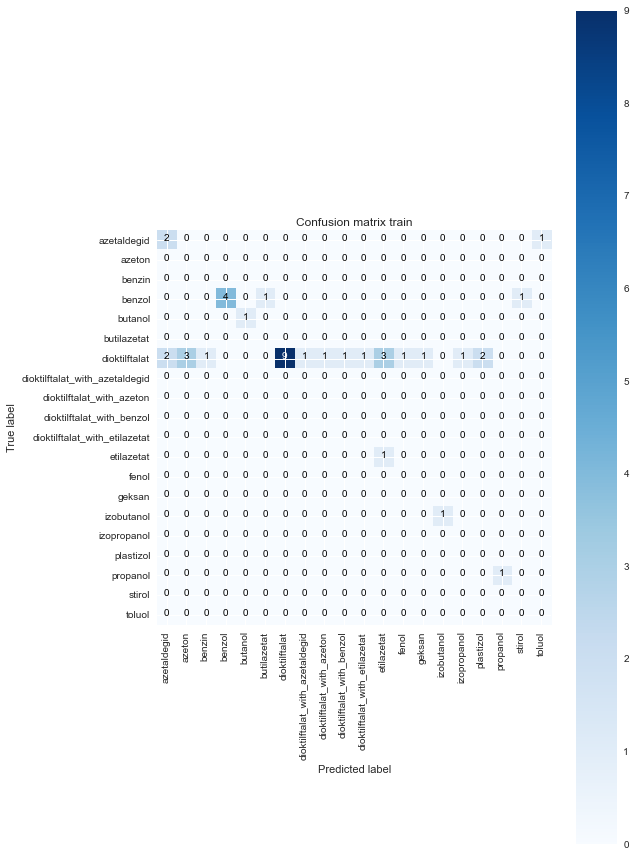

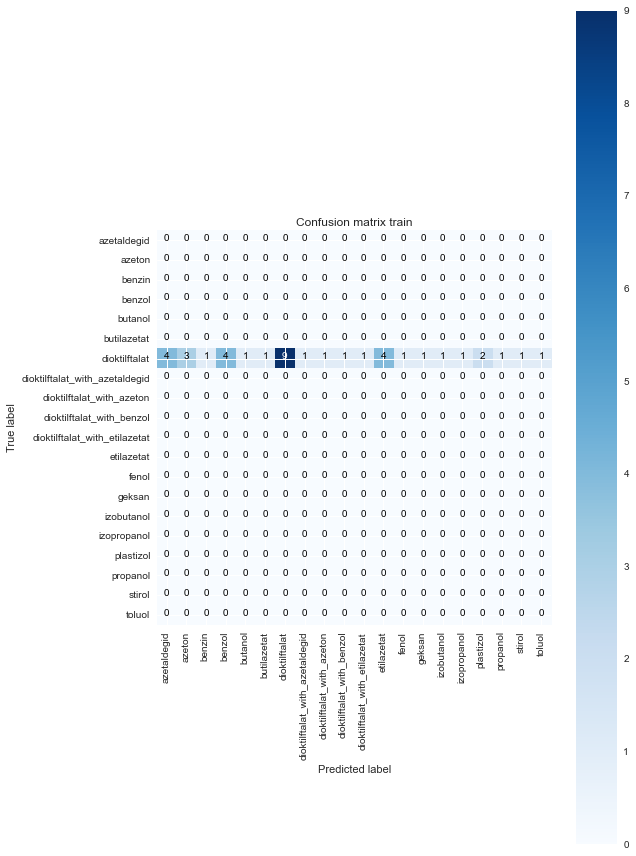

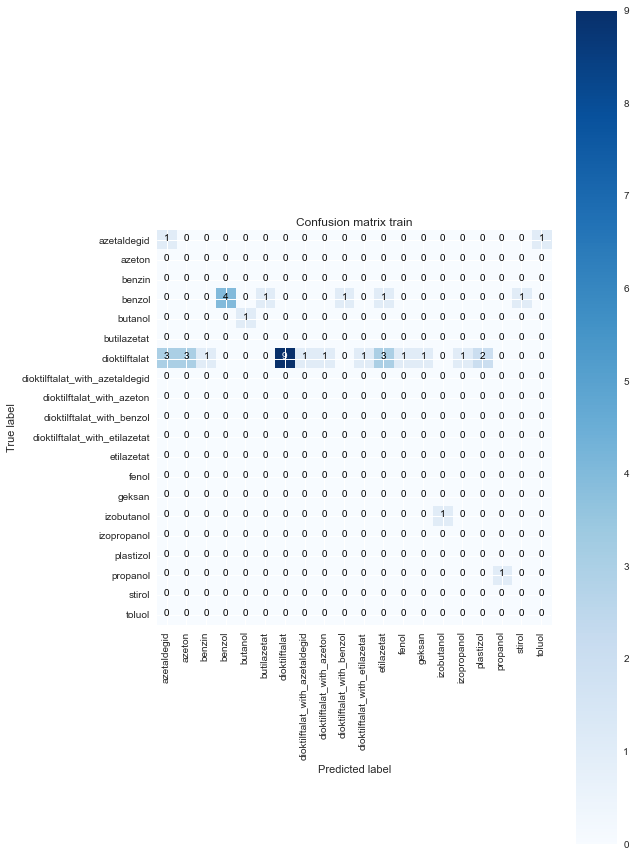

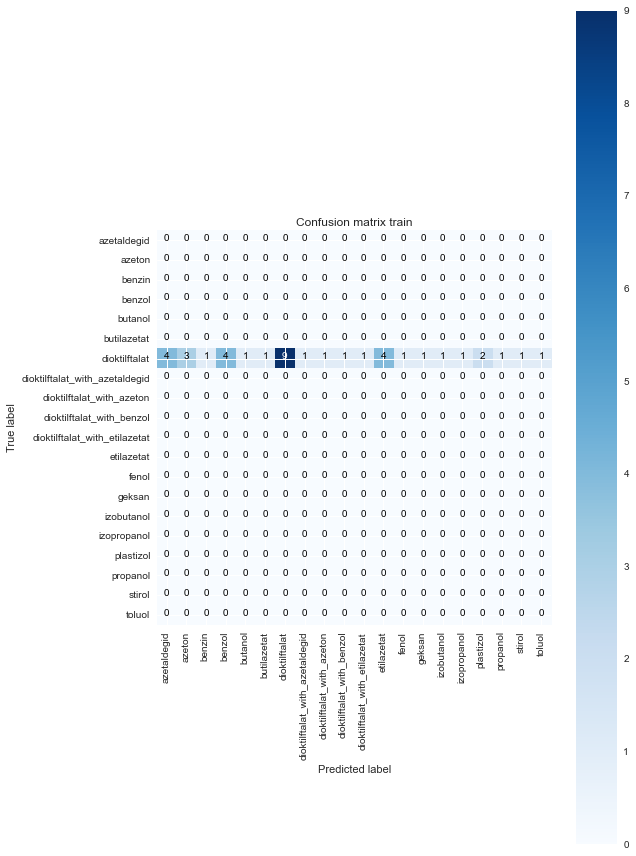

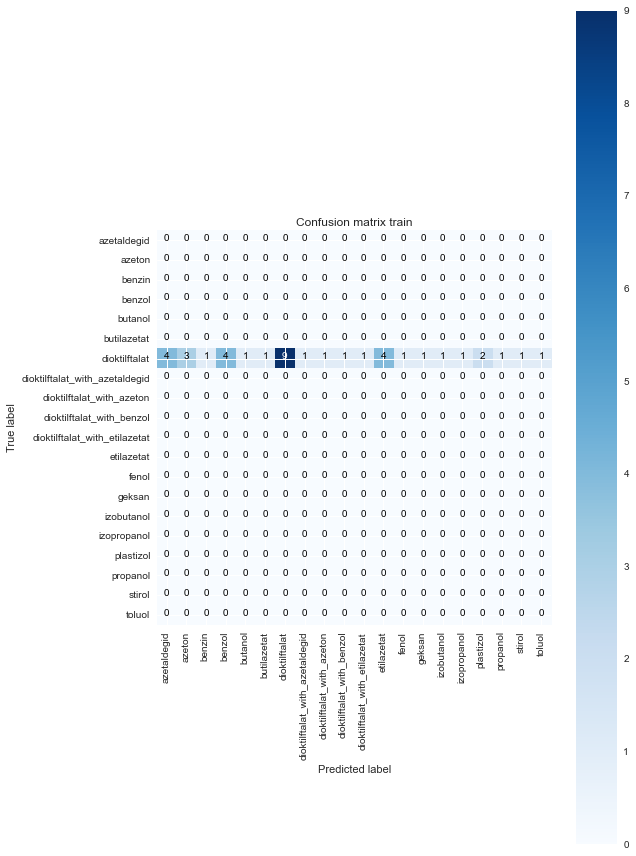

In [95]:
scales = [['Raw', X_train_raw], ['StandardScaler', df_std], ['MinMaxScaler', df_minmax], ['RobustScaler', df_robust], \
['MaxAbsScaler', df_maxabs], ['Normalizer', df_norma]]
from sklearn.svm import SVC
clf = SVC()
for sc in scales:
    clf.fit(sc[1], y_train2)
    y_score = clf.predict(sc[1])
    err_train = np.mean(y_train2 != y_score)
    print ("SVM train accuracy for "+sc[0], 1 - err_train)
    from sklearn.metrics import classification_report
    print(classification_report(y_train2, y_score, target_names=clf.classes_))
    from sklearn.metrics import confusion_matrix
    cnf_matrix_train = confusion_matrix(y_score, y_train2)    
    np.set_printoptions(precision=2)
    class_names = list(clf.classes_)
    plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [259]:
scales = [['Raw', X_train_raw], ['StandardScaler', df_std], ['MinMaxScaler', df_minmax], ['RobustScaler', df_robust], \
          ['MaxAbsScaler', df_maxabs], ['Normalizer', df_norma]]
from sklearn.decomposition import PCA
pca = PCA()
for sc in scales:
    pca.fit(sc[1])
    print("EVR for "+ sc[0], pca.explained_variance_ratio_[:8])

EVR for Raw [ 0.69  0.17  0.1   0.02  0.01  0.01  0.    0.  ]
EVR for StandardScaler [ 0.45  0.17  0.08  0.05  0.04  0.03  0.03  0.02]
EVR for MinMaxScaler [ 0.43  0.16  0.08  0.05  0.05  0.04  0.03  0.02]
EVR for RobustScaler [ 0.44  0.19  0.08  0.05  0.04  0.04  0.03  0.01]
EVR for MaxAbsScaler [ 0.3   0.14  0.09  0.06  0.06  0.05  0.03  0.03]
EVR for Normalizer [ 0.54  0.21  0.06  0.04  0.03  0.02  0.02  0.01]


In [284]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets, feature_selection
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC())])

In [273]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_raw, y_train2)
y_score = clf.predict(X_train_raw)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.95


Отличная точность! Проблемы только с гексаном и ДОФ с ацетоном - SVM принимает их за ДОФ.

Confusion matrix, without normalization


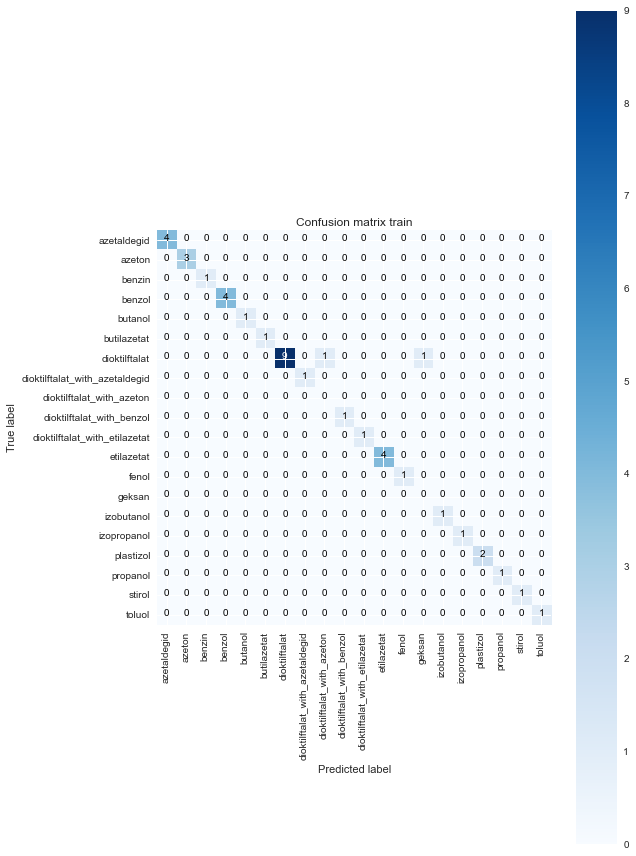

In [24]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      1.00      1.00         4
                        azeton       1.00      1.00      1.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       1.00      1.00      1.00         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.82      1.00      0.90         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       1.00      1.00      1.00         1
                    etilazetat       1.00      1.00      1.00         4
                         fenol       1.00      1.00      1.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Подберем параметры:

In [26]:
kfold = model_evaluation(X_train_raw, y_train2, 2)  

from sklearn.svm import SVC  
from sklearn.grid_search import GridSearchCV
Gammas = [0.001, 0.01, 1, 10]
kernels = ['rbf', 'linear', 'sigmoid']
decision_function = ['ovo', 'ovr']
coefs = [0.0, 0.5, 1.0, 10.0, 100.0]
class_weight = ['balanced', 'auto']
Cs = [0.001, 0.01, 1, 10]

svc_grid = GridSearchCV(estimator = (SVC()), 
    param_grid = {'C': Cs, 'gamma': Gammas, 'kernel': kernels, 
    'decision_function_shape': decision_function,
    'coef0': coefs, 'class_weight': class_weight },
    cv = kfold, n_jobs = 1)

svc_grid.fit(X_train_raw, y_train2)

print ("best score:", svc_grid.best_score_)
print ("best params: ", svc_grid.best_params_)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated

best score: 0.275
best params:  {'kernel': 'linear', 'decision_function_shape': 'ovo', 'coef0': 0.0, 'C': 0.01, 'class_weight': 'balanced', 'gamma': 0.001}


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


In [27]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=0.01, coef0=0.0, class_weight='balanced', gamma=0.001, decision_function_shape='ovo')
clf.fit(X_train_raw, y_train2)
y_score = clf.predict(X_train_raw)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  1.0


Похоже, переобучились. Посмотрим, как это сработает на multilabel-задаче.

In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier( SVC(kernel='linear', C=0.01, coef0=0.0, class_weight='balanced',
                               gamma=0.001, decision_function_shape='ovo', probability=True) )
clf.fit(X_train_raw, y_train)
y_score =  clf.predict(X_train_raw) 
err_train = np.mean(y_train != y_score)
print ("svm train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_raw)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")


svm train accuracy:  1.0
1
[('dioktilftalat', '0.500'), ('azetaldegid', '0.150'), ('etilazetat', '0.105'), ('azeton', '0.098'), ('benzol', '0.085'), ('plastizol', '0.065')]
{'azeton', 'dioktilftalat'}
------------------
2
[('dioktilftalat', '0.730'), ('benzol', '0.115'), ('etilazetat', '0.104'), ('azetaldegid', '0.088'), ('azeton', '0.083'), ('dioktilftalat_with_azetaldegid', '0.054')]
{'azeton', 'dioktilftalat'}
------------------
3
[('dioktilftalat', '0.549'), ('azetaldegid', '0.135'), ('plastizol', '0.118'), ('etilazetat', '0.106'), ('benzol', '0.082'), ('azeton', '0.079')]
{'plastizol'}
------------------
4
[('benzol', '0.453'), ('dioktilftalat', '0.144'), ('etilazetat', '0.103'), ('butilazetat', '0.073'), ('dioktilftalat_with_azetaldegid', '0.059'), ('propanol', '0.050')]
{'dioktilftalat_with_etilazetat', 'izopropanol', 'dioktilftalat_with_azetaldegid', 'toluol', 'butilazetat', 'izobutanol'}
------------------
5
[('benzol', '0.447'), ('etilazetat', '0.104'), ('butilazetat', '0.062

# Learning on dFmax

In [29]:
X_train, y_train, X_new, mlb = load_dataset()

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


In [30]:
X_train_fmax = get_dfmax(X_train)
X_new_fmax = get_dfmax(X_new)

In [31]:
X_train_fmax = np.array(X_train_fmax)
n_samples = len(X_train_fmax)
X_train_fmax = X_train_fmax.reshape((n_samples, -1))

In [32]:
X_new_fmax = np.array(X_new_fmax)
n_samples = len(X_new_fmax)
X_new_fmax = X_new_fmax.reshape((n_samples, -1))

In [33]:
from sklearn import preprocessing
X_train_fmax = preprocessing.scale(X_train_fmax)
X_new_fmax = preprocessing.scale(X_new_fmax)

In [34]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_fmax, y_train2)
y_score = clf.predict(X_train_fmax)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.525


Недоучились. Попробуем подобрать параметры - есть шанс улучшить точность.

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      1.00      1.00         4
                        azeton       1.00      0.33      0.50         3
                        benzin       0.00      0.00      0.00         1
                        benzol       0.44      1.00      0.62         4
                       butanol       0.00      0.00      0.00         1
                   butilazetat       0.00      0.00      0.00         1
                 dioktilftalat       0.39      1.00      0.56         9
dioktilftalat_with_azetaldegid       0.00      0.00      0.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       0.00      0.00      0.00         1
 dioktilftalat_with_etilazetat       0.00      0.00      0.00         1
                    etilazetat       1.00      0.25      0.40         4
                         fenol       0.00      0.00      0.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
kfold = model_evaluation(X_train_fmax, y_train2, 2)  

from sklearn.svm import SVC  
from sklearn.grid_search import GridSearchCV
Gammas = [0.001, 0.01, 1, 10]
kernels = ['rbf', 'linear', 'sigmoid']
decision_function = ['ovo', 'ovr']
coefs = [0.0, 0.5, 1.0, 10.0, 100.0]
class_weight = ['balanced', 'auto']
Cs = [0.001, 0.01, 1, 10]

svc_grid = GridSearchCV(estimator = (SVC()), 
    param_grid = {'C': Cs, 'gamma': Gammas, 'kernel': kernels, 
    'decision_function_shape': decision_function,
    'coef0': coefs, 'class_weight': class_weight },
    cv = kfold, n_jobs = 1)

svc_grid.fit(X_train_fmax, y_train2)

print ("best score:", svc_grid.best_score_)
print ("best params: ", svc_grid.best_params_)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated

best score: 0.225
best params:  {'kernel': 'rbf', 'decision_function_shape': 'ovo', 'coef0': 0.0, 'C': 0.001, 'class_weight': 'auto', 'gamma': 0.01}


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


In [37]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=0.001, coef0=0.0, class_weight='auto', gamma=0.01, decision_function_shape='ovo')
clf.fit(X_train_fmax, y_train2)
y_score = clf.predict(X_train_fmax)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  1.0


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Переобучение

Confusion matrix, without normalization


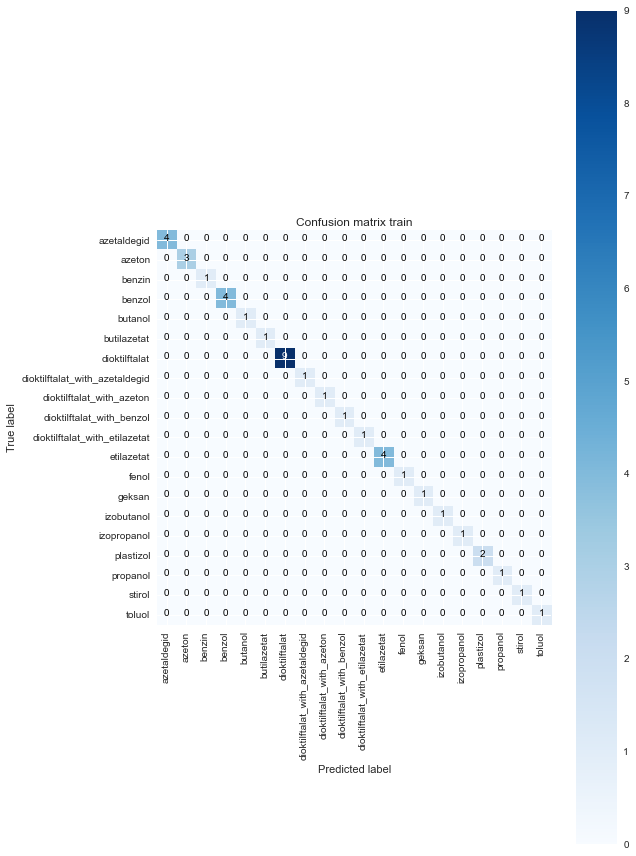

In [38]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      1.00      1.00         4
                        azeton       1.00      1.00      1.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       1.00      1.00      1.00         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       1.00      1.00      1.00         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       1.00      1.00      1.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       1.00      1.00      1.00         1
                    etilazetat       1.00      1.00      1.00         4
                         fenol       1.00      1.00      1.00  

Посмотрим на multilabel.

In [40]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier( SVC(kernel='rbf', C=0.001, coef0=0.0,  gamma=0.01, decision_function_shape='ovo', probability=True) )
clf.fit(X_train_fmax, y_train)
y_score =  clf.predict(X_train_fmax) 
err_train = np.mean(y_train != y_score)
print ("svm train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_fmax)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")

svm train accuracy:  0.95
1
[('dioktilftalat', '0.226'), ('azetaldegid', '0.109'), ('etilazetat', '0.106'), ('plastizol', '0.092'), ('benzol', '0.083'), ('azeton', '0.079')]
{'azeton', 'dioktilftalat'}
------------------
2
[('dioktilftalat', '0.225'), ('azetaldegid', '0.109'), ('etilazetat', '0.106'), ('plastizol', '0.092'), ('benzol', '0.083'), ('azeton', '0.079')]
{'azeton', 'dioktilftalat'}
------------------
3
[('dioktilftalat', '0.225'), ('azetaldegid', '0.109'), ('etilazetat', '0.106'), ('plastizol', '0.092'), ('benzol', '0.083'), ('azeton', '0.079')]
{'plastizol'}
------------------
4
[('dioktilftalat', '0.188'), ('azetaldegid', '0.109'), ('etilazetat', '0.109'), ('plastizol', '0.092'), ('azeton', '0.080'), ('benzol', '0.070')]
{'dioktilftalat_with_etilazetat', 'izopropanol', 'dioktilftalat_with_azetaldegid', 'toluol', 'butilazetat', 'izobutanol'}
------------------
5
[('dioktilftalat', '0.221'), ('azetaldegid', '0.110'), ('etilazetat', '0.106'), ('plastizol', '0.092'), ('benzol

# Learning on cross-correlation matrices

In [133]:
X_train, y_train_bin, X_new, mlb = load_dataset()
y_train2 = load_labels("data/labels_all.txt")
y_train = []
for item in y_train2:
    y_train.append([item])
y_train = mlb.fit_transform(y_train)

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


Посмотрим на взаимную корреляцию сенсоров. Видно, что везде показания сильно коррелированы, характер корреляции - положительный. По матрицам взаимной кореляци можно выделить характерные признаки:
- Ацелальдегид (1 или 6 сенсор), однако показания не всегда точны
- ДОФ - там у всех сенсоров, кроме 6, взаимная корреляция близка к +1, в то время как 6 имеет сильную отрицательную корреляцию, более -0.5, ближе к -0.8. 
- Бензина и бензол - по сенсору 1 их матрциы похожи
- Гексан - определеяется двумя сенсорами - 1 и 6.
- Для изобутанола так же имеет определяющее значение сенсор 1.
- Для изопропанола - сенсор 6
- Пластизоль определяется сенсорами 1 (отрицательная корреляция) и 6 (слабая положительная)
- Для определения стирола решающую роль играют показания сенсора 5 - там взаимная корреляция гораздо ниже, чем у прочих
- Толуол - сенсор 6, однако корреляция сильня положительная
- Этилацетат - нулевой сенсор у одного объекта, средняя положительная корреляция, и 3 у объектов - сенсор 1
- ДОФ с ацетоном - сенсоры 0 и 6
- ДОФ с бензолом - сенсроы 5 и 6

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


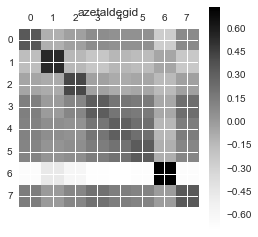

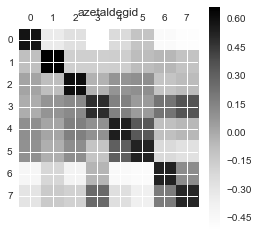

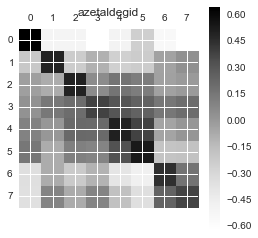

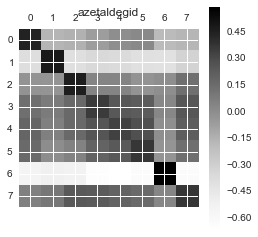

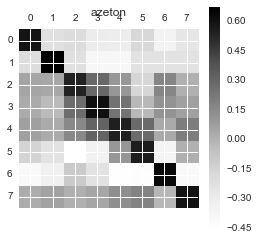

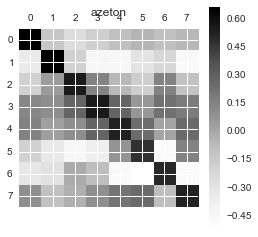

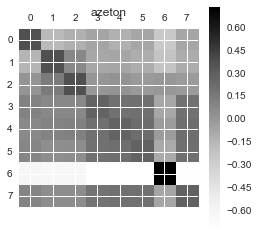

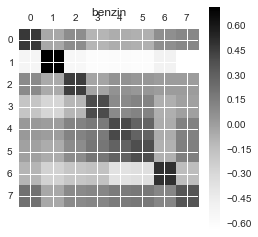

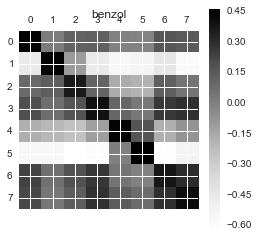

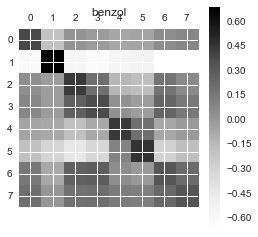

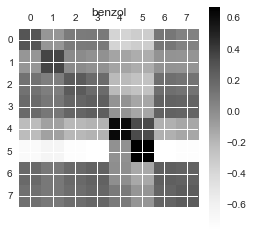

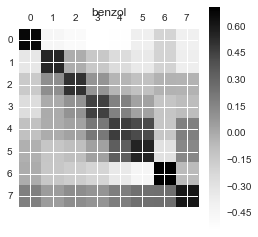

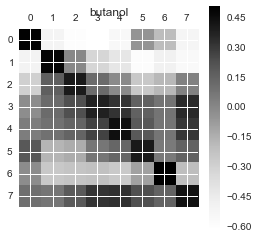

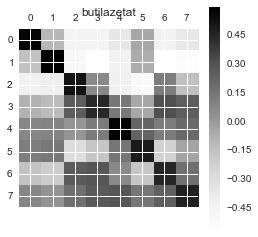

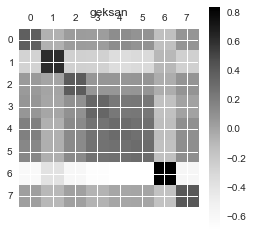

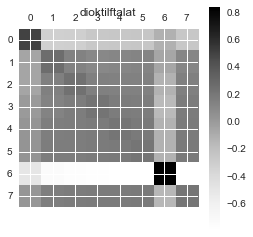

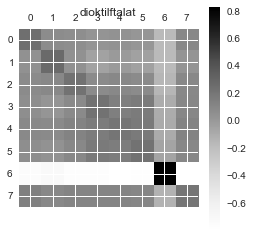

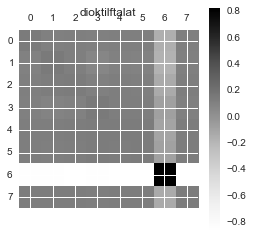

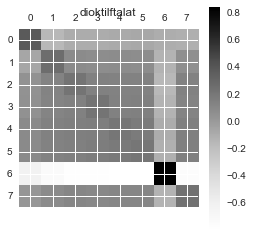

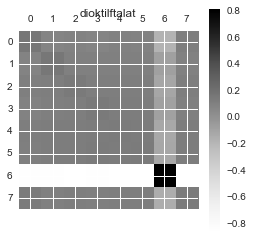

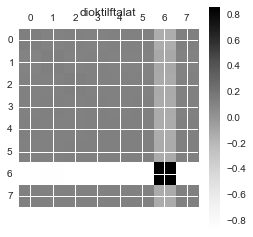

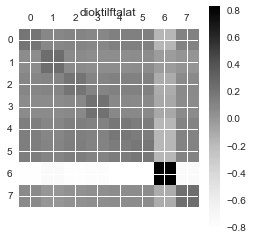

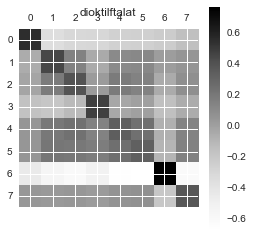

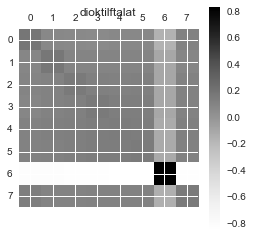

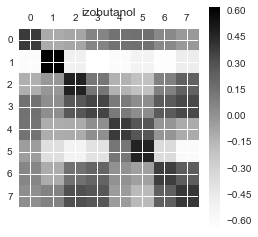

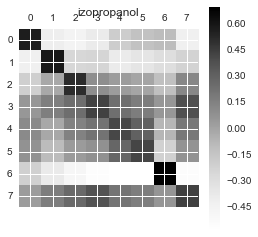

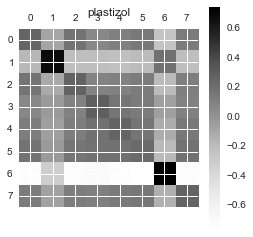

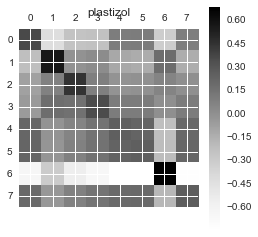

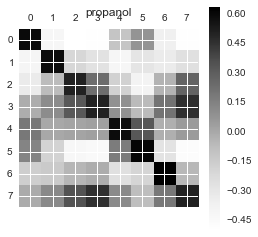

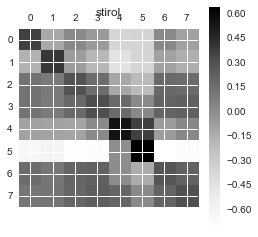

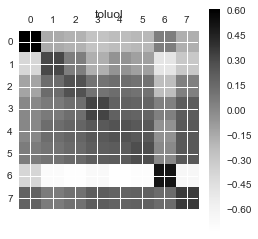

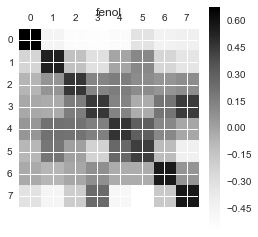

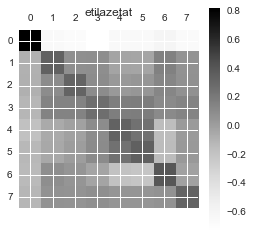

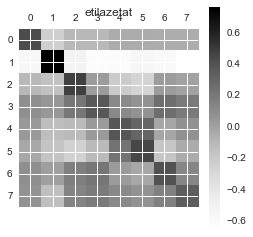

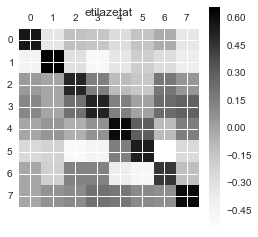

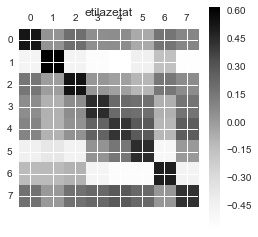

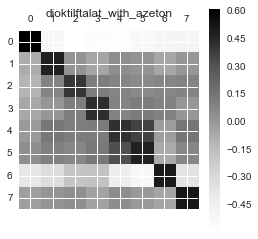

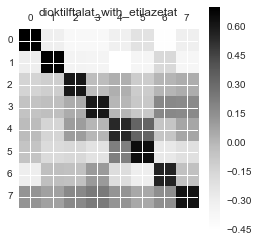

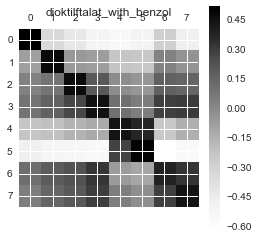

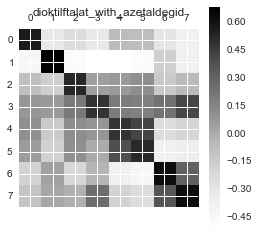

In [134]:
X_train_corr = []
for X, y in zip(X_train, y_train2):
    X = list(map(list, zip(*X)))
    df = pd.DataFrame(X, index=None, columns=["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
    corr = df.corr()
    corr = (corr - corr.mean()) / (corr.max() - corr.min())
    X_train_corr.append(corr.as_matrix())
    plt.matshow(corr)
    plt.colorbar()
    plt.title(y)
#plt.close('all')

Посмотрим на матрицы взаимной корреляции игрушек. Сходные фигуры наблюдаются и здесь.

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


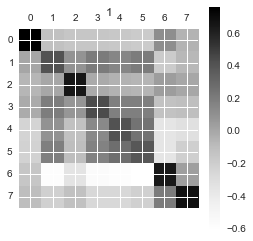

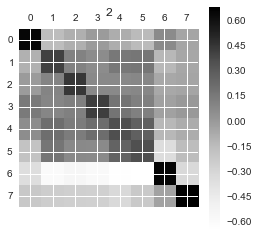

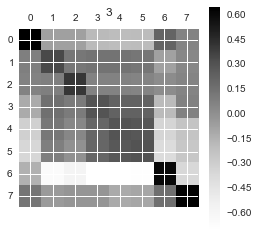

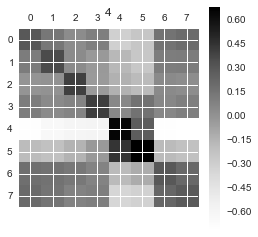

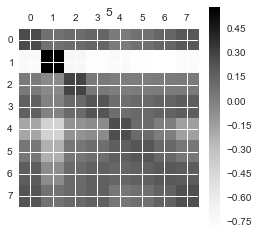

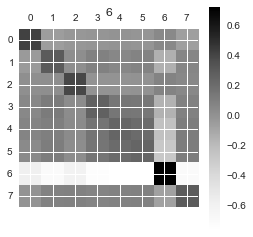

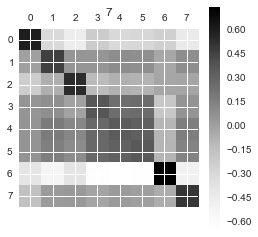

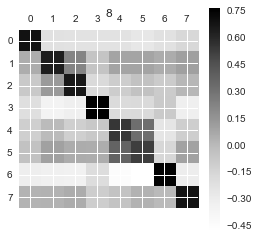

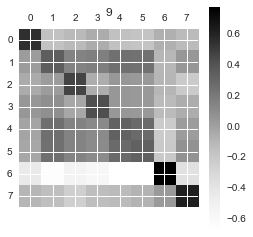

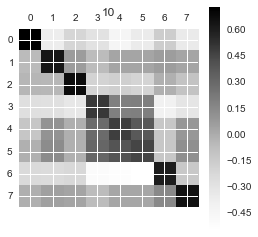

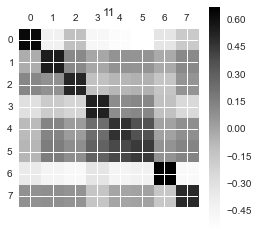

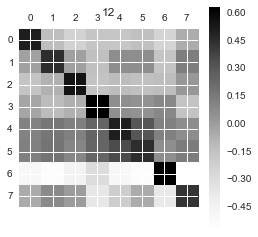

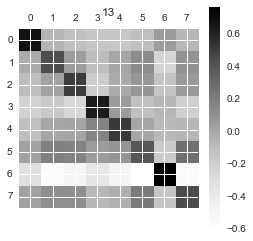

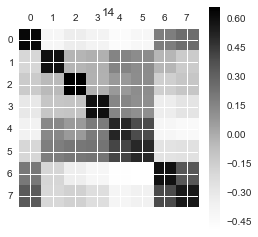

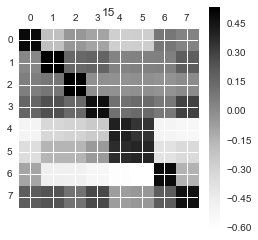

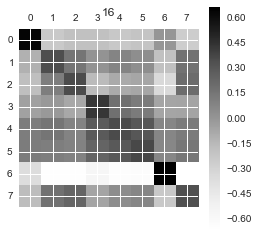

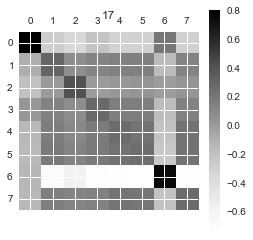

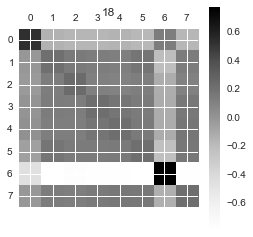

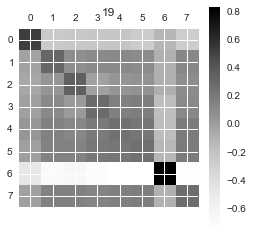

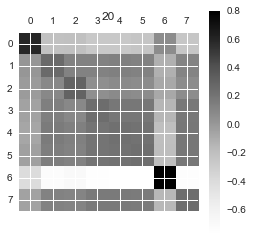

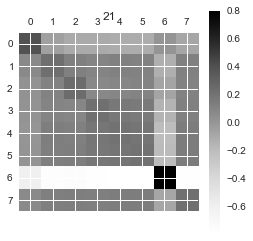

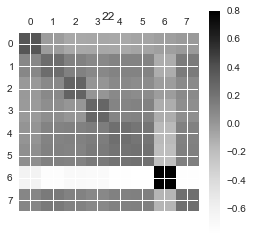

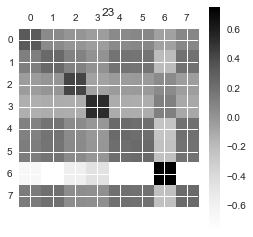

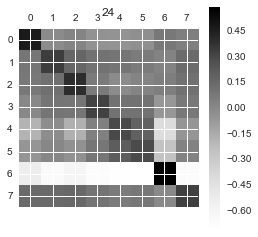

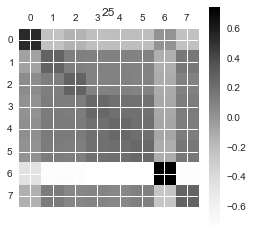

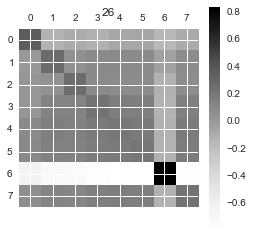

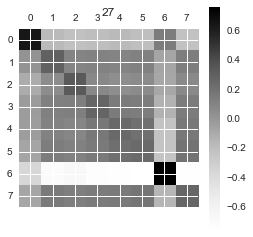

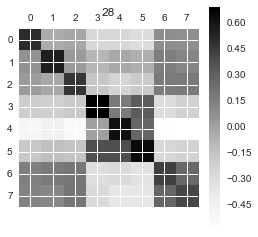

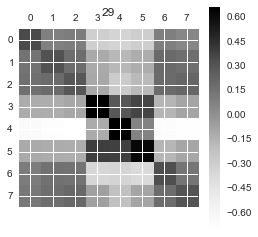

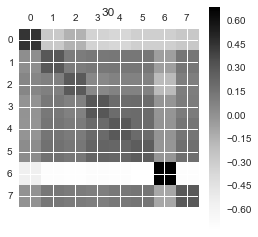

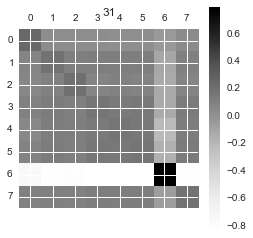

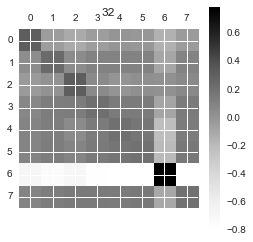

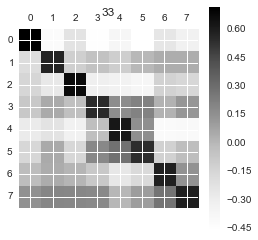

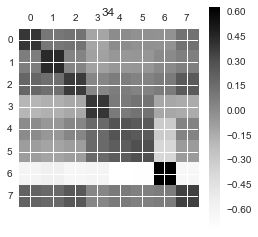

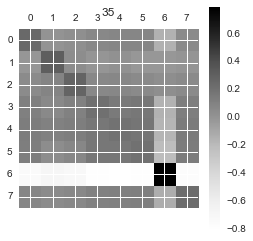

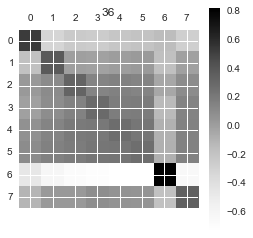

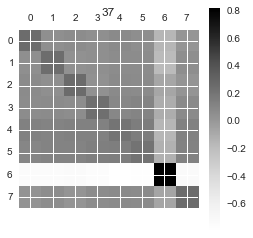

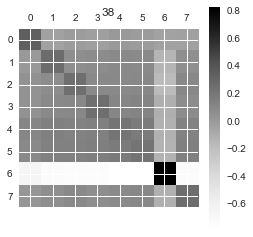

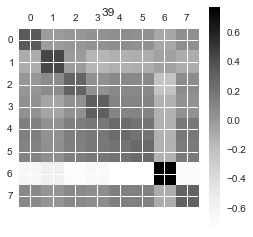

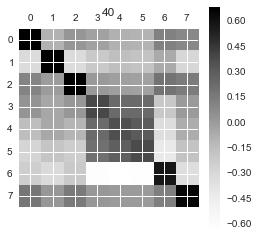

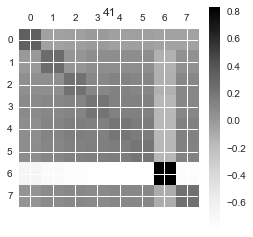

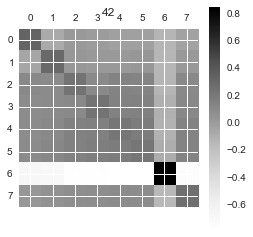

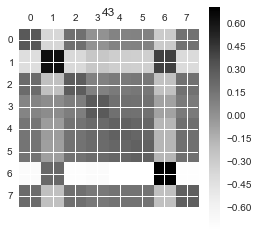

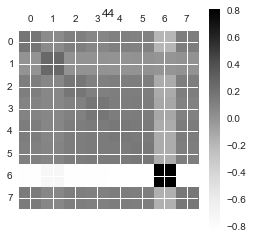

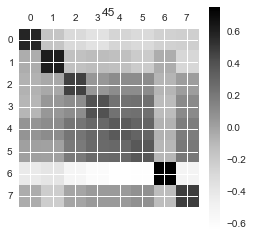

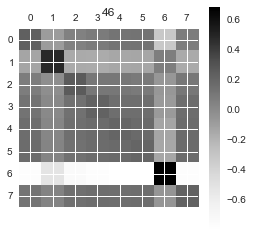

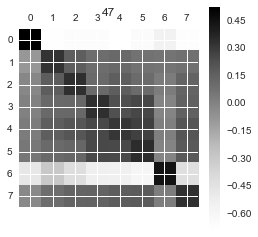

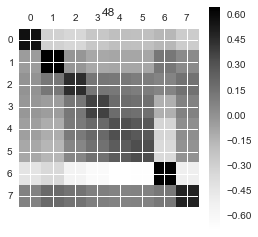

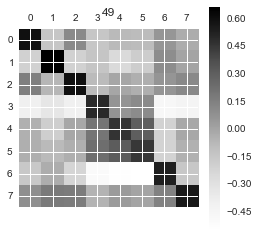

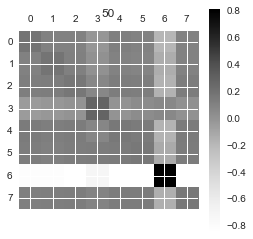

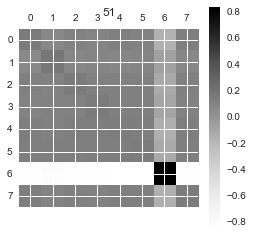

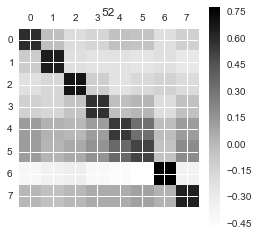

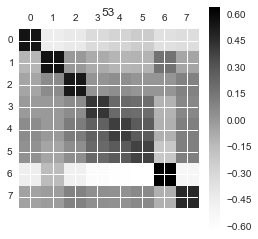

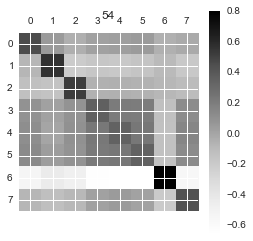

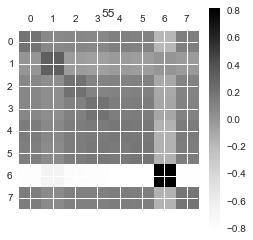

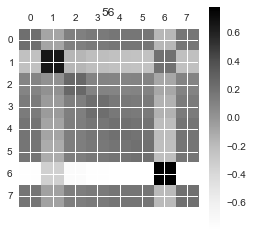

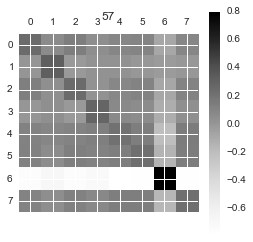

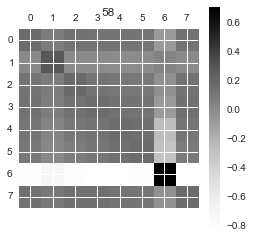

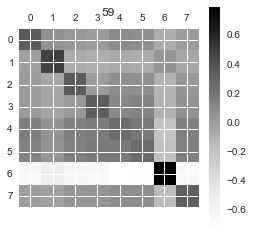

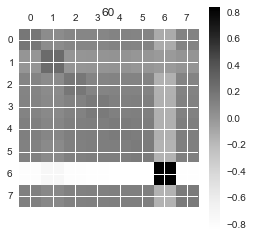

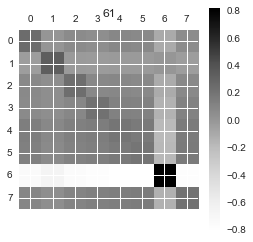

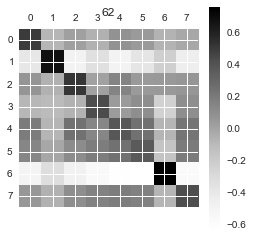

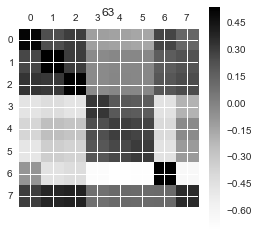

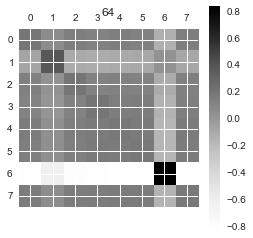

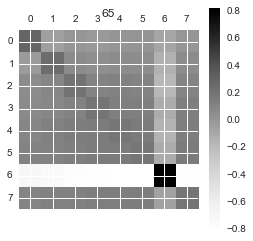

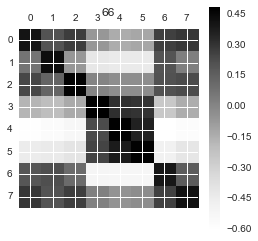

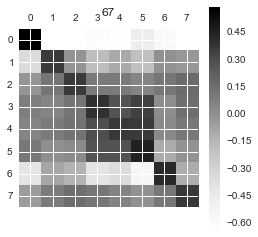

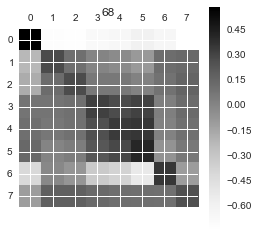

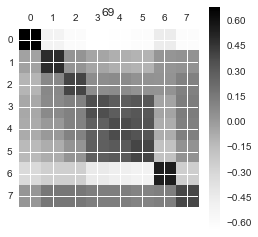

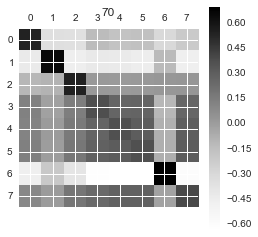

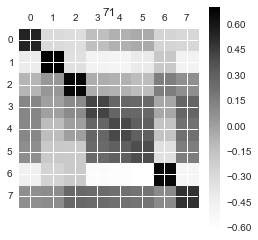

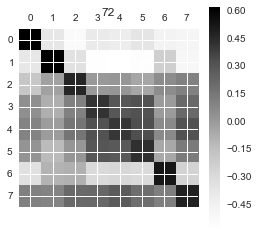

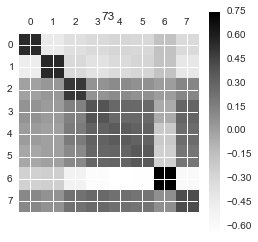

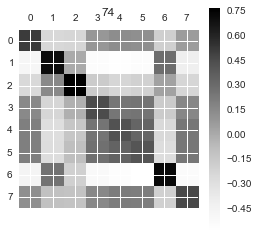

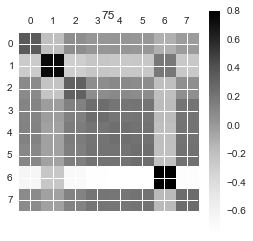

In [135]:
X_new_corr = []
for X, y in zip(X_new, range(1,76)):
    X = list(map(list, zip(*X)))
    df = pd.DataFrame(X, index=None, columns=["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
    corr = df.corr()
    corr = (corr - corr.mean()) / (corr.max() - corr.min())
    X_new_corr.append(corr.as_matrix())
    plt.matshow(corr)
    plt.colorbar()
    plt.title(y)
#plt.close('all')

In [136]:
X_train_corr = np.array(X_train_corr)
n_samples = len(X_train_corr)
X_train_corr = X_train_corr.reshape((n_samples, -1))

In [137]:
X_new_corr = np.array(X_new_corr)
n_samples = len(X_new_corr)
X_new_corr = X_new_corr.reshape((n_samples, -1))

In [55]:
#df = pd.DataFrame(X_train_corr, index=None, columns=None)
#df.describe()

In [90]:
#from sklearn import preprocessing
#X_train_corr = preprocessing.scale(X_train_corr)
#X_new_corr = preprocessing.scale(X_new_corr)

In [138]:
df = pd.DataFrame(X_train_corr, index=None, columns=None)

In [227]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(df)
df_std = std_scale.transform(df)

minmax_scale = preprocessing.MinMaxScaler().fit(df)
df_minmax = minmax_scale.transform(df)

robust_scale = preprocessing.RobustScaler().fit(df)
df_robust = robust_scale.transform(df)

maxabs_scale = preprocessing.MaxAbsScaler().fit(df)
df_maxabs = maxabs_scale.transform(df)

norma = preprocessing.Normalizer().fit(df)
df_norma = norma.transform(df)

In [228]:
print ("StandardScaler")
print('Mean after standardization:{:.2f}'.format(df_std[:,0].mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_std[:,0].std()))
print ("\nMinMaxScaler")
print('Mean after standardization:{:.2f}'.format(df_minmax[:,0].mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_minmax[:,0].std()))
print ("\nRobustScaler")
print('Mean after standardization:{:.2f}'.format(df_robust[:,0].mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_robust[:,0].std()))
print ("\nMaxAbsScaler")
print('Mean after standardization:{:.2f}'.format(df_maxabs[:,0].mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_maxabs[:,0].std()))
print ("\nNormalizer")
print('Mean after standardization:{:.2f}'.format(df_norma[:,0].mean()))
print('Standard deviation after standardization:{:.2f}'.format(df_norma[:,0].std()))

StandardScaler
Mean after standardization:0.00
Standard deviation after standardization:1.00

MinMaxScaler
Mean after standardization:0.47
Standard deviation after standardization:0.25

RobustScaler
Mean after standardization:-0.10
Standard deviation after standardization:0.76

MaxAbsScaler
Mean after standardization:0.56
Standard deviation after standardization:0.21

Normalizer
Mean after standardization:0.19
Standard deviation after standardization:0.07


In [214]:
scales = [['StandardScaler', df_std], ['MinMaxScaler', df_minmax], ['RobustScaler', df_robust], \
          ['MaxAbsScaler', df_maxabs], ['Normalizer', df_norma]]
from sklearn.svm import SVC
clf = SVC()
for sc in scales:
    clf.fit(sc[1], y_train2)
    y_score = clf.predict(sc[1])
    err_train = np.mean(y_train2 != y_score)
    print ("SVM train accuracy for "+sc[0], 1 - err_train)

SVM train accuracy for StandardScaler 0.7
SVM train accuracy for MinMaxScaler 0.35
SVM train accuracy for RobustScaler 0.55
SVM train accuracy for MaxAbsScaler 0.4
SVM train accuracy for Normalizer 0.225


In [215]:
scales = [['StandardScaler', df_std], ['MinMaxScaler', df_minmax], ['RobustScaler', df_robust], \
          ['MaxAbsScaler', df_maxabs], ['Normalizer', df_norma]]
from sklearn.decomposition import PCA
pca = PCA()
for sc in scales:
    pca.fit(sc[1])
    print("EVR for "+ sc[0], pca.explained_variance_ratio_[:8])

EVR for StandardScaler [ 0.38  0.16  0.11  0.07  0.06  0.04  0.04  0.03]
EVR for MinMaxScaler [ 0.45  0.15  0.11  0.05  0.05  0.04  0.03  0.02]
EVR for RobustScaler [ 0.3   0.19  0.12  0.08  0.07  0.04  0.04  0.03]
EVR for MaxAbsScaler [ 0.43  0.15  0.11  0.06  0.05  0.05  0.03  0.02]
EVR for Normalizer [ 0.54  0.16  0.1   0.05  0.03  0.02  0.02  0.02]


In [218]:
from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSSVD
from sklearn.cross_decomposition import PLSCanonical
from sklearn.decomposition import TruncatedSVD

cca = TruncatedSVD()
df_norma = cca.fit(df_std, y_train).transform(df_std)
print (cca.explained_variance_ratio_ )

[ 0.38  0.16]


In [219]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(df_norma, y_train2)
y_score = clf.predict(df_norma)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.825


In [230]:
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline

# ANOVA SVM-C
anova_filter = SelectKBest(f_regression, k=2)
clf = svm.SVC()

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(df_norma, y_train2)
y_score = anova_svm.predict(df_norma)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

TypeError: cannot perform reduce with flexible type

In [161]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_corr, y_train2)
y_score = clf.predict(X_train_corr)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.3


Точность без нормализации матриц: 0.475, а с нормализацией - 0.3
<br> Точность с нормазиацией без масштабирования - 0.3, а с масштабированием - 0.7
<br> явно ниже ожидаемого.

Confusion matrix, without normalization


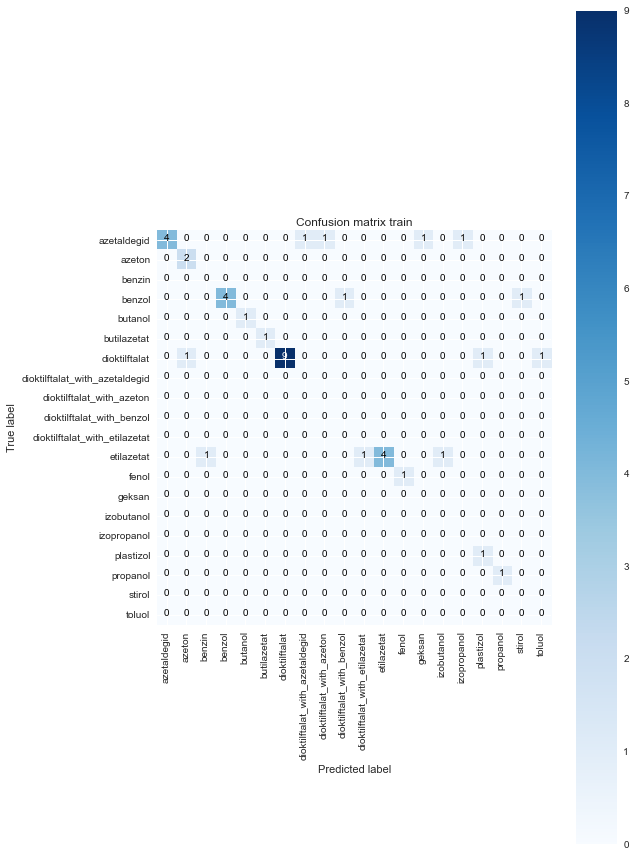

In [92]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       0.50      1.00      0.67         4
                        azeton       1.00      0.67      0.80         3
                        benzin       0.00      0.00      0.00         1
                        benzol       0.67      1.00      0.80         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.75      1.00      0.86         9
dioktilftalat_with_azetaldegid       0.00      0.00      0.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       0.00      0.00      0.00         1
 dioktilftalat_with_etilazetat       0.00      0.00      0.00         1
                    etilazetat       0.57      1.00      0.73         4
                         fenol       1.00      1.00      1.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Попробуем подобрать параметры.

In [221]:
kfold = model_evaluation(X_train_corr, y_train2, 2)  

from sklearn.svm import SVC  
from sklearn.grid_search import GridSearchCV
Gammas = [0.001, 0.01, 1, 10]
kernels = ['rbf', 'linear', 'sigmoid']
decision_function = ['ovo', 'ovr']
coefs = [0.0, 0.5, 1.0, 10.0, 100.0]
Cs = [0.001, 0.01, 1, 10]

svc_grid = GridSearchCV(estimator = (SVC(class_weight='balanced')), 
    param_grid = {'C': Cs, 'gamma': Gammas, 'kernel': kernels, 
    'decision_function_shape': decision_function,
    'coef0': coefs},
    cv = kfold, n_jobs = 1)

svc_grid.fit(X_train_corr, y_train2)

print ("best score:", svc_grid.best_score_)
print ("best params: ", svc_grid.best_params_)

best score: 0.35
best params:  {'gamma': 0.001, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'kernel': 'linear', 'C': 1}


In [223]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1, coef0=0.0, class_weight='auto', gamma=1, decision_function_shape='ovo')
clf.fit(X_train_corr, y_train2)
y_score = clf.predict(X_train_corr)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.725


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Результат после подбора параметров улучшился вдвое. Посмотрим, как поведёт себя алгоритм на multilabel-задаче.

Confusion matrix, without normalization


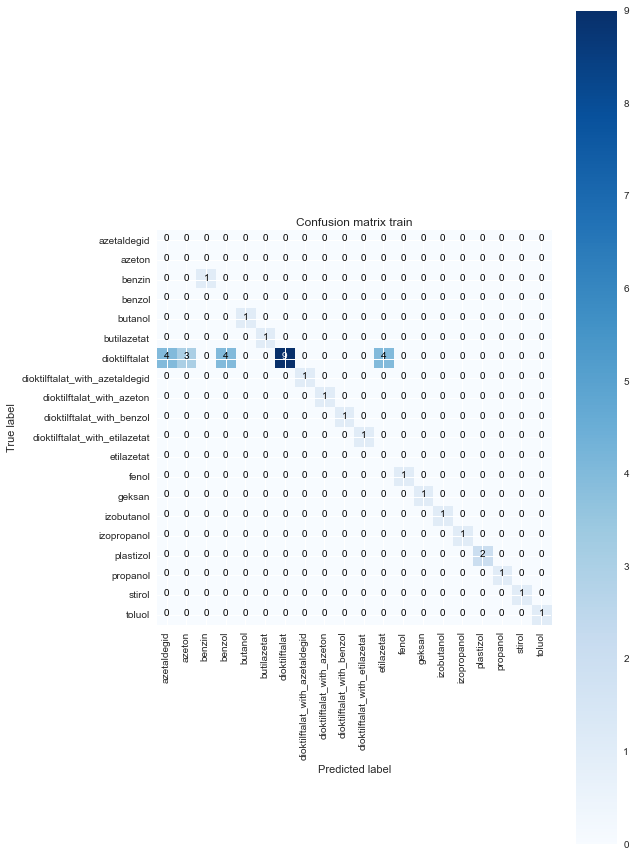

In [96]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(clf.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [97]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       0.00      0.00      0.00         4
                        azeton       0.00      0.00      0.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       0.00      0.00      0.00         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.38      1.00      0.55         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       1.00      1.00      1.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       1.00      1.00      1.00         1
                    etilazetat       0.00      0.00      0.00         4
                         fenol       1.00      1.00      1.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [224]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier( SVC(kernel='rbf', C=1, coef0=0.0, gamma=1, decision_function_shape='ovo', probability=True) )
clf.fit(X_train_corr, y_train)
y_score =  clf.predict(X_train_corr) 
err_train = np.mean(y_train != y_score)
print ("svm train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_corr)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")


svm train accuracy:  0.98


ValueError: X.shape[1] = 64 should be equal to 2, the number of features at training time

# Principal component analysis of each matrix

In [98]:
X_train, y_train_bin, X_new, mlb = load_dataset()
y_train2 = load_labels("data/labels_all.txt")

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)


In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

Попутно посмотрим на отношение столбцов в матрицах. Ранг всех матриц равен 8 => имеем 8 линейно независимых столбцов.

In [74]:
from numpy.linalg import matrix_rank 

X_train2 = []
for X, i in zip(X_train, range(1,len(X_train)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_train2.append(list(pca.transform(X)))  
    evr4 = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + \
    pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3]
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], " + ", \
            '%.4f' % pca.explained_variance_ratio_[1], " + ", \
           '%.4f' % pca.explained_variance_ratio_[2], " + ", \
            '%.4f' % pca.explained_variance_ratio_[3], " = ", \
           '%.4f' % evr4, \
           "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.9343  +  0.0242  +  0.0105  +  0.0082  =  0.9772 ; число линейно независимых строк и столбцов:  8
2  ->  0.9818  +  0.0126  +  0.0013  +  0.0011  =  0.9969 ; число линейно независимых строк и столбцов:  8
3  ->  0.9917  +  0.0056  +  0.0006  +  0.0005  =  0.9985 ; число линейно независимых строк и столбцов:  8
4  ->  0.9657  +  0.0132  +  0.0049  +  0.0043  =  0.9881 ; число линейно независимых строк и столбцов:  8
5  ->  0.9743  +  0.0132  +  0.0036  +  0.0024  =  0.9935 ; число линейно независимых строк и столбцов:  8
6  ->  0.9868  +  0.0069  +  0.0016  +  0.0013  =  0.9965 ; число линейно независимых строк и столбцов:  8
7  ->  0.9768  +  0.0081  +  0.0036  +  0.0029  =  0.9915 ; число линейно независимых строк и столбцов:  8
8  ->  0.8936  +  0.0381  +  0.0197  +  0.0126  =  0.9641 ; число линейно независимых строк и столбцов:  8
9  ->  0.9714  +  0.0128  +  0.0040  +  0.0031  =  0.9913 ; число линейно независимых строк и столбцов:  8
10  ->  0.9884  +  0.0054  +  0.0017 

Видно, что первая компонента объясняет не менее 88% процентов дисперсии исходной модели. Для большинства веществ-маркеров эта цифра стремится к 100%. Посмотрим, что происходит с главными компонентами в матрицаз обеих видов. Синий - это пример матрицы, где объяснённаяя дисперсия первой компоненты стремится к 100%, зелёный - 88%. На обоих графиках поведение одинаковое.

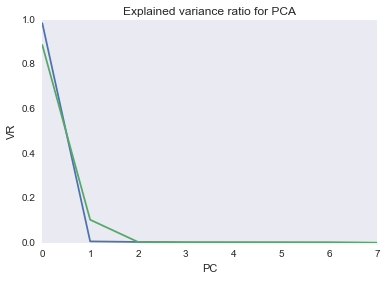

In [75]:
pca = PCA()
pca.fit(X_train[6])
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio for PCA")
plt.xlabel('PC')
plt.ylabel('VR')
plt.grid()
pca.fit(X_train[39])
plt.plot(pca.explained_variance_ratio_)

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

Попутно посмотрим на отношение столбцов в матрицах. Ранг всех матриц равен 8 => имеем 8 линейно независимых столбцов.

In [77]:
from numpy.linalg import matrix_rank 

X_new2 = []
for X,i in zip(X_new, range(1,len(X_new)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_new2.append(list(pca.transform(X)))
    evr4 = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + \
    pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3]
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], " + ", \
            '%.4f' % pca.explained_variance_ratio_[1], " + ", \
           '%.4f' % pca.explained_variance_ratio_[2], " + ", \
            '%.4f' % pca.explained_variance_ratio_[3], " = ", \
           '%.4f' % evr4, \
           "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.7535  +  0.0963  +  0.0585  +  0.0272  =  0.9355 ; число линейно независимых строк и столбцов:  8
2  ->  0.8644  +  0.0612  +  0.0196  +  0.0142  =  0.9594 ; число линейно независимых строк и столбцов:  8
3  ->  0.8620  +  0.0818  +  0.0144  +  0.0115  =  0.9696 ; число линейно независимых строк и столбцов:  8
4  ->  0.9616  +  0.0265  +  0.0033  +  0.0024  =  0.9938 ; число линейно независимых строк и столбцов:  8
5  ->  0.9515  +  0.0307  +  0.0063  +  0.0030  =  0.9915 ; число линейно независимых строк и столбцов:  8
6  ->  0.8944  +  0.0400  +  0.0176  +  0.0132  =  0.9652 ; число линейно независимых строк и столбцов:  8
7  ->  0.9553  +  0.0139  +  0.0069  +  0.0061  =  0.9822 ; число линейно независимых строк и столбцов:  8
8  ->  0.8322  +  0.0577  +  0.0242  +  0.0220  =  0.9360 ; число линейно независимых строк и столбцов:  8
9  ->  0.8496  +  0.0394  +  0.0308  +  0.0248  =  0.9446 ; число линейно независимых строк и столбцов:  8
10  ->  0.9605  +  0.0167  +  0.0052 

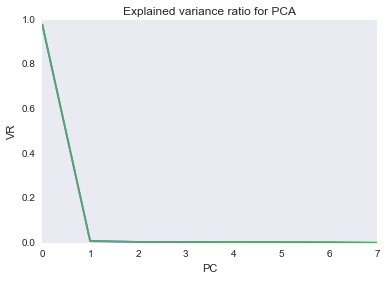

In [78]:
pca = PCA()
pca.fit(X_new[6])
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio for PCA")
plt.xlabel('PC')
plt.ylabel('VR')
plt.grid()
pca.fit(X_new[39])
plt.plot(pca.explained_variance_ratio_)

Видно, что для игрушек происходит то же самое

In [99]:
X_train2 = np.array(X_train2)
print (X_train2.shape)
nsamples00, nx, ny = X_train2.shape
X_train2 = X_train2.reshape((nsamples00,nx*ny))        

X_new2 = np.array(X_new2)
print (X_new2.shape)
nsamples00, nx, ny = X_new2.shape
X_new2 = X_new2.reshape((nsamples00,nx*ny))  

(40, 484)


ValueError: need more than 2 values to unpack

In [80]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train2, y_train2)
y_score = clf.predict(X_train2)
err_train = np.mean(y_train2 != y_score)
print ("SVM train accuracy: ", 1 - err_train)

SVM train accuracy:  0.75


In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=clf.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       0.80      1.00      0.89         4
                        azeton       1.00      0.67      0.80         3
                        benzin       0.00      0.00      0.00         1
                        benzol       1.00      1.00      1.00         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.50      1.00      0.67         9
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       0.00      0.00      0.00         1
     dioktilftalat_with_benzol       0.00      0.00      0.00         1
 dioktilftalat_with_etilazetat       0.00      0.00      0.00         1
                    etilazetat       1.00      0.50      0.67         4
                         fenol       1.00      1.00      1.00  

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Итак, получили представление каждого сенсора в виде одного числа. Теперь посмотрим на отношения внутри полученного вектора.

## Linear discriminant analysis

Превращение в двухмерную матрицу (до этого шага имелась одна лишняя "пустая" размерность)

При этом, если мы и дальше планируем развивать этот подход, нас интересует именно такое представление этих данных, чтобы расстояние между классами было максимально. Иными словами, радикально уменьшая размерность обучающего множества со 121-мерного до 8-, а то и 2-мерного, нужно позаботиться о качестве распознавания. Поскольку линейный дискриминант - это supervised-метод, он даст нам именно то, что нужно.

In [109]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='svd') 

In [110]:
y_train2 = load_labels("data/labels_all.txt")
lda.fit(X_train2, y_train2)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [111]:
print (lda.explained_variance_ratio_ )

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'explained_variance_ratio_'

Первые 2 фактора дадут нам 95% дисперии исходной модели.

In [112]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda =  LinearDiscriminantAnalysis(n_components=2, solver='svd') 
lda.fit(X_train2, y_train2)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [113]:
X = lda.transform(X_train2)
X_new2 = lda.transform(X_new2)

ValueError: operands could not be broadcast together with shapes (75,2) (484,) 

In [135]:
lda.get_params().keys()

dict_keys(['tol', 'priors', 'shrinkage', 'store_covariance', 'solver', 'n_components'])

In [136]:
kfold = model_evaluation(X_train2, y_train2, 2)  

from sklearn.grid_search import GridSearchCV
solvers = ['svd']
n_components  = [1, 2, 3, 4, 5, 6, 7, 8]

lda_grid = GridSearchCV(estimator = LinearDiscriminantAnalysis(), 
    param_grid = { 'solver': solvers, 'n_components': n_components},
    cv = kfold, n_jobs = 1)

lda_grid.fit(X_train2, y_train2)

print ("best score:", lda_grid.best_score_)
print ("best params: ", lda_grid.best_params_)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variabl

best score: 0.05
best params:  {'solver': 'svd', 'n_components': 1}


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Обучим модель и посмотрим, с какой точностью LDA способен работать с этими данными.

In [137]:
y_score = lda.predict(X_train2)
err_train = np.mean(y_train2 != y_score)
print ("LDA train accuracy: ", 1 - err_train)

LDA train accuracy:  0.8


Точность составляет 80%, а анализ матрицы ошибок показывает, что:
- Модель хорошо различает: ацетальдегид, ацетон, бензин, бензол, бутанол, бутилацетат, ДОФ с ацетальдегидом, ДОФ с ацетоном, ДОФ с бензолом, фенол, изобутанол, изопропанол, пропанол, стирол, толуол.
- Для ацетона - 2 объекта назначены правильно, 1 ошибочно отнесён в ДОФ
- Для ДОФ - 8 объектов верны, 1 объект ошибочно назначен этилацетатом, 1 гексаном и 1 пластизолью
- ДОФ с этилацетатом перепутана с чистым этилацетатом

Confusion matrix, without normalization


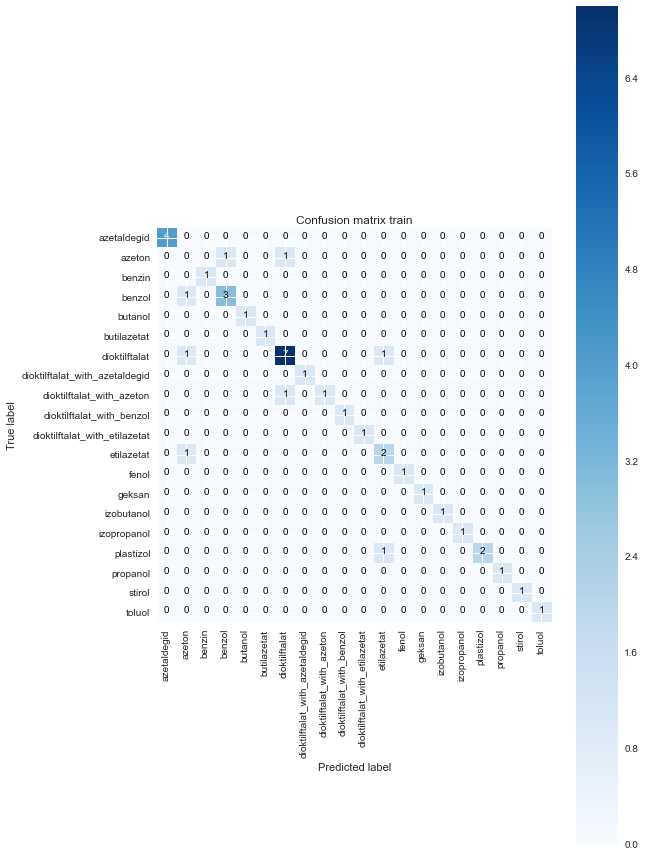

In [138]:
from sklearn.metrics import confusion_matrix
cnf_matrix_train = confusion_matrix(y_score, y_train2)    
np.set_printoptions(precision=2)
class_names = list(lda.classes_)
plot_confusion_matrix(cnf_matrix_train, classes=class_names, title='Confusion matrix train')

In [139]:
#from sklearn.metrics import classification_report
#print(classification_report(y_train2, y_score, target_names=clf.classes_))

In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier( LinearDiscriminantAnalysis(n_components=2, solver='svd')  )
clf.fit(X_train_corr, y_train)
y_score =  clf.predict(X_train_corr) 
err_train = np.mean(y_train != y_score)
print ("LDA train accuracy: ", 1 - err_train)

y_new_proba = clf.predict_proba(X_new_corr)
y_test_true_labels = load_labels("true_labels.txt")
y_test_true_labels = [list(filter(None, lab)) for lab in y_test_true_labels]
for y_pred,y_tr,i in zip(y_new_proba,y_test_true_labels,range(len(X_new))):
    print (i+1)
    r1 = [(c,"{:.3f}".format(yy)) for c,yy in zip(mlb.classes_,y_pred)]
    sorted_by_second_1 = sorted(r1, key=lambda tup: tup[1], reverse=True)
    print (sorted_by_second_1[:6])
    print (set(y_tr))
    print ("------------------")


C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are

LDA train accuracy:  0.995
1
[('benzol', '1.000'), ('butanol', '1.000'), ('butilazetat', '1.000'), ('etilazetat', '1.000'), ('izobutanol', '1.000'), ('propanol', '1.000')]
{'azeton', 'dioktilftalat'}
------------------
2
[('azetaldegid_with_dioktilftalat', '1.000'), ('azeton', '1.000'), ('benzol', '1.000'), ('etilazetat', '1.000'), ('geksan', '1.000'), ('izopropanol', '1.000')]
{'azeton', 'dioktilftalat'}
------------------
3
[('azetaldegid_with_dioktilftalat', '1.000'), ('benzol', '1.000'), ('butanol', '1.000'), ('butilazetat', '1.000'), ('etilazetat', '1.000'), ('izobutanol', '1.000')]
{'plastizol'}
------------------
4
[('benzol', '1.000'), ('butanol', '1.000'), ('butilazetat', '1.000'), ('etilazetat', '1.000'), ('izobutanol', '1.000'), ('propanol', '1.000')]
{'dioktilftalat_with_azetaldegid', 'izopropanol', 'izobutanol', 'butilazetat', 'toluol', 'dioktilftalat_with_etilazetat'}
------------------
5
[('azeton', '1.000'), ('dioktilftalat_with_etilazetat', '1.000'), ('etilazetat', '1.

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [141]:
df = pd.DataFrame(X, index=None, columns=["C0", "C1"])

In [142]:
df.describe()

,C0,C1
count,4.000000e+01,4.000000e+01
mean,-2.498002e-16,-5.412337e-16
std,2.618779e+00,1.595486e+00
min,-8.277857e+00,-3.739733e+00
25%,-1.163579e+00,-5.007435e-01
50%,8.247109e-01,6.734368e-02
75%,1.731482e+00,9.654094e-01
max,3.585169e+00,5.395704e+00


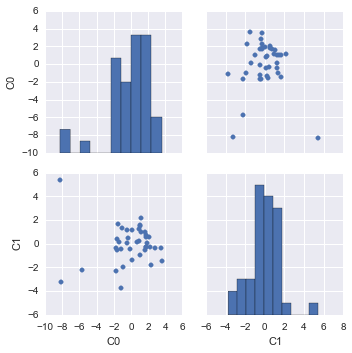

In [143]:
g = sns.pairplot(df, kind="scatter")

Нормализуем:

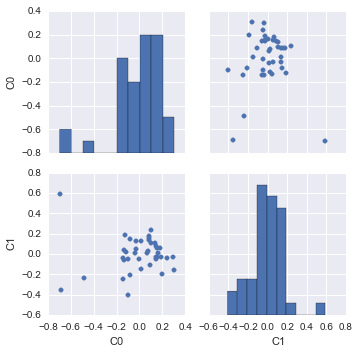

In [144]:
df = (df - df.mean()) / (df.max() - df.min())
g = sns.pairplot(df, kind="scatter")

In [145]:
df.describe()

,C0,C1
count,4.000000e+01,4.000000e+01
mean,-1.387779e-18,6.938894e-19
std,2.207514e-01,1.746481e-01
min,-6.977863e-01,-4.093655e-01
25%,-9.808449e-02,-5.481331e-02
50%,6.951944e-02,7.371697e-03
75%,1.459562e-01,1.056774e-01
max,3.022137e-01,5.906345e-01


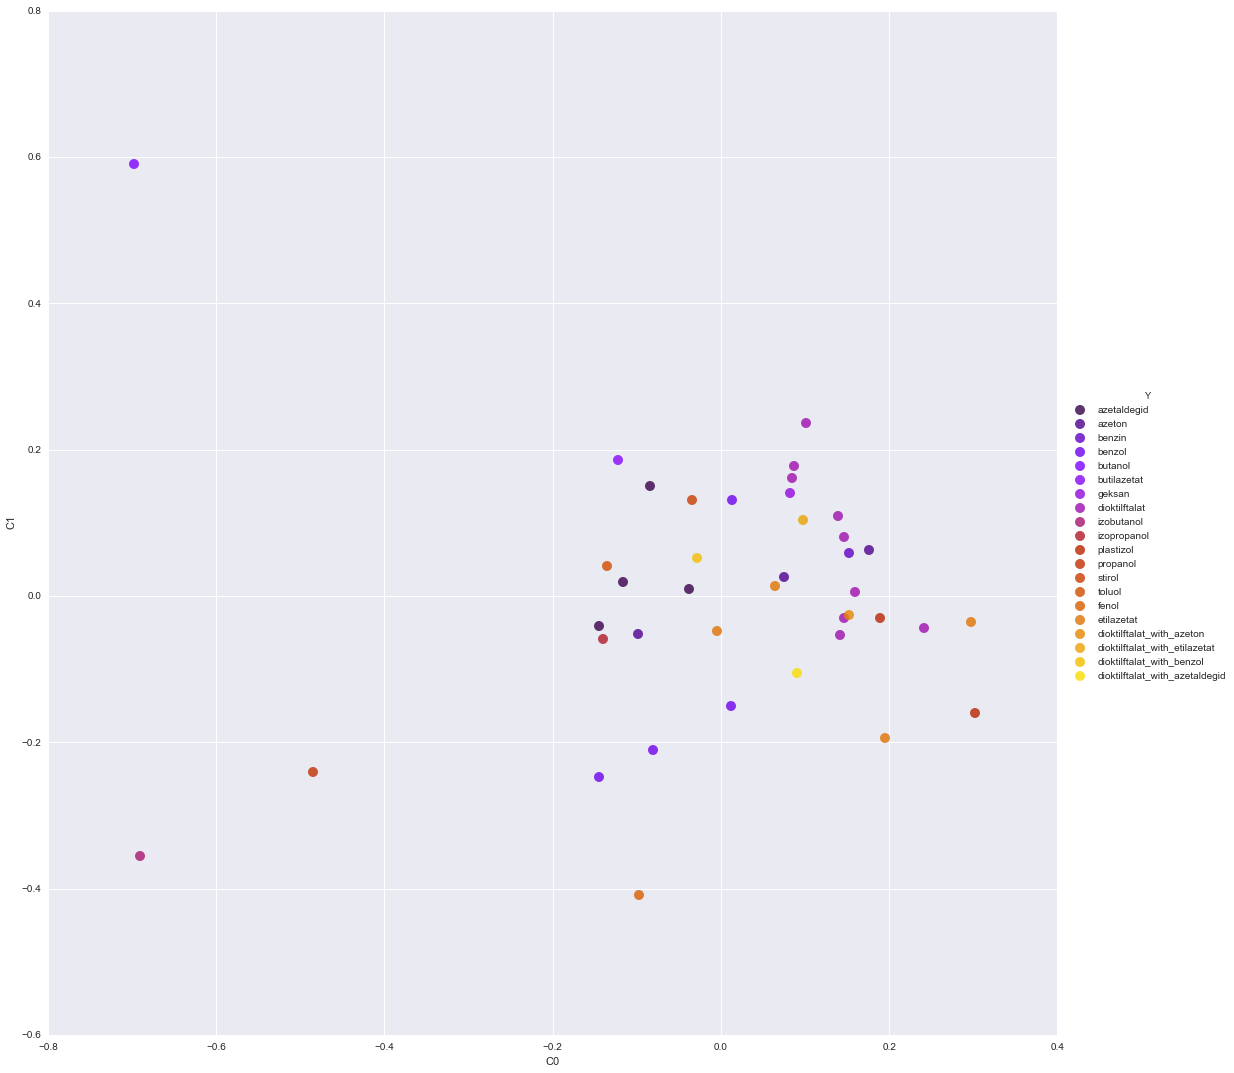

In [146]:
df["Y"] = y_train2
g = sns.lmplot(x="C0", y="C1", hue="Y", fit_reg=False, scatter_kws={"s": 100}, data=df, palette="gnuplot", size=15)
plt.savefig("")

# Learning on data without outliers

In [147]:
X_train, y_train_bin, X_new, mlb = load_dataset()

X_train_out = load_data("data/data_all_outliers.txt")
y_train_out = load_labels("data/labels_all_outliers.txt")

print ("Data without outliers: ", np.array(X_train_out).shape)

y_train_out_2 = []
for item in y_train_out:
    y_train_out_2.append([item])
y_train_out_2 = mlb.fit_transform(y_train_out_2)

initial data:  (36, 8, 121)
initial data:  (4, 8, 121)
initial data:  (75, 8, 121)
Data without outliers:  (37, 8, 121)


In [148]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

In [149]:
from numpy.linalg import matrix_rank 
X_train2 = []
for X,i in zip(X_train_out, range(1,len(X_train_out)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_train2.append(list(pca.transform(X)))
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.9818 ; число линейно независимых строк и столбцов:  8
2  ->  0.9917 ; число линейно независимых строк и столбцов:  8
3  ->  0.9657 ; число линейно независимых строк и столбцов:  8
4  ->  0.9743 ; число линейно независимых строк и столбцов:  8
5  ->  0.9868 ; число линейно независимых строк и столбцов:  8
6  ->  0.9768 ; число линейно независимых строк и столбцов:  8
7  ->  0.8936 ; число линейно независимых строк и столбцов:  8
8  ->  0.9714 ; число линейно независимых строк и столбцов:  8
9  ->  0.9884 ; число линейно независимых строк и столбцов:  8
10  ->  0.9916 ; число линейно независимых строк и столбцов:  8
11  ->  0.9842 ; число линейно независимых строк и столбцов:  8
12  ->  0.9978 ; число линейно независимых строк и столбцов:  8
13  ->  0.9903 ; число линейно независимых строк и столбцов:  8
14  ->  0.8803 ; число линейно независимых строк и столбцов:  8
15  ->  0.9721 ; число линейно независимых строк и столбцов:  8
16  ->  0.9945 ; число линейно независимых строк 

In [150]:
from numpy.linalg import matrix_rank 
X_new2 = []
for X,i in zip(X_new, range(1,len(X_new)+1)):
    X = list(map(list, zip(*X)))
    pca.fit(X)
    X_new2.append(list(pca.transform(X)))
    print (i, " -> ", '%.4f' % pca.explained_variance_ratio_[0], "; число линейно независимых строк и столбцов: ", matrix_rank(X))

1  ->  0.7535 ; число линейно независимых строк и столбцов:  8
2  ->  0.8644 ; число линейно независимых строк и столбцов:  8
3  ->  0.8620 ; число линейно независимых строк и столбцов:  8
4  ->  0.9616 ; число линейно независимых строк и столбцов:  8
5  ->  0.9515 ; число линейно независимых строк и столбцов:  8
6  ->  0.8944 ; число линейно независимых строк и столбцов:  8
7  ->  0.9553 ; число линейно независимых строк и столбцов:  8
8  ->  0.8322 ; число линейно независимых строк и столбцов:  8
9  ->  0.8496 ; число линейно независимых строк и столбцов:  8
10  ->  0.9605 ; число линейно независимых строк и столбцов:  8
11  ->  0.9690 ; число линейно независимых строк и столбцов:  8
12  ->  0.9392 ; число линейно независимых строк и столбцов:  8
13  ->  0.5927 ; число линейно независимых строк и столбцов:  8
14  ->  0.9555 ; число линейно независимых строк и столбцов:  8
15  ->  0.9822 ; число линейно независимых строк и столбцов:  8
16  ->  0.9828 ; число линейно независимых строк 

In [151]:
X_train2 = np.array(X_train2)
print (X_train2.shape)
nsamples00, nx, ny = X_train2.shape
X_train2 = X_train2.reshape((nsamples00,nx*ny))        

X_new2 = np.array(X_new2)
print (X_new2.shape)
nsamples00, nx, ny = X_new2.shape
X_new2 = X_new2.reshape((nsamples00,nx*ny))  

(37, 121, 1)
(75, 121, 1)


In [152]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda =  LinearDiscriminantAnalysis(solver='svd') 
y_train2 = load_labels("data/labels_all_outliers.txt")
lda.fit(X_train2, y_train2)

C:\Users\ashadrin\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [153]:
X = lda.transform(X_train2)
X_new2 = lda.transform(X_new2)

In [154]:
y_score = lda.predict(X_train2)
err_train = np.mean(y_train2 != y_score)
print ("LDA train accuracy: ", 1 - err_train)

LDA train accuracy:  0.756756756757


Удаление выбросов уменьшает точность.

In [155]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_score, target_names=lda.classes_))

                                precision    recall  f1-score   support

                   azetaldegid       1.00      0.67      0.80         3
                        azeton       0.00      0.00      0.00         3
                        benzin       1.00      1.00      1.00         1
                        benzol       0.60      0.75      0.67         4
                       butanol       1.00      1.00      1.00         1
                   butilazetat       1.00      1.00      1.00         1
                 dioktilftalat       0.75      0.86      0.80         7
dioktilftalat_with_azetaldegid       1.00      1.00      1.00         1
     dioktilftalat_with_azeton       1.00      1.00      1.00         1
     dioktilftalat_with_benzol       1.00      1.00      1.00         1
 dioktilftalat_with_etilazetat       0.50      1.00      0.67         1
                    etilazetat       0.50      0.50      0.50         4
                         fenol       1.00      1.00      1.00  